In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import math

(train, test) , info = tfds.load('mnist', split =['train', 'test'], 
                                 as_supervised=True , with_info=True)

2023-02-14 23:21:51.101059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 23:21:51.605206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-14 23:21:51.605241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-14 23:21:51.605246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/mortimer/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",


1. How manny train/test images are there? — 60,000/10,000
2. Whats the image shape? — (28, 28, 1)
3. What rage are the pixel values in? — [0; 255]


2022-11-23 14:16:54.426598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


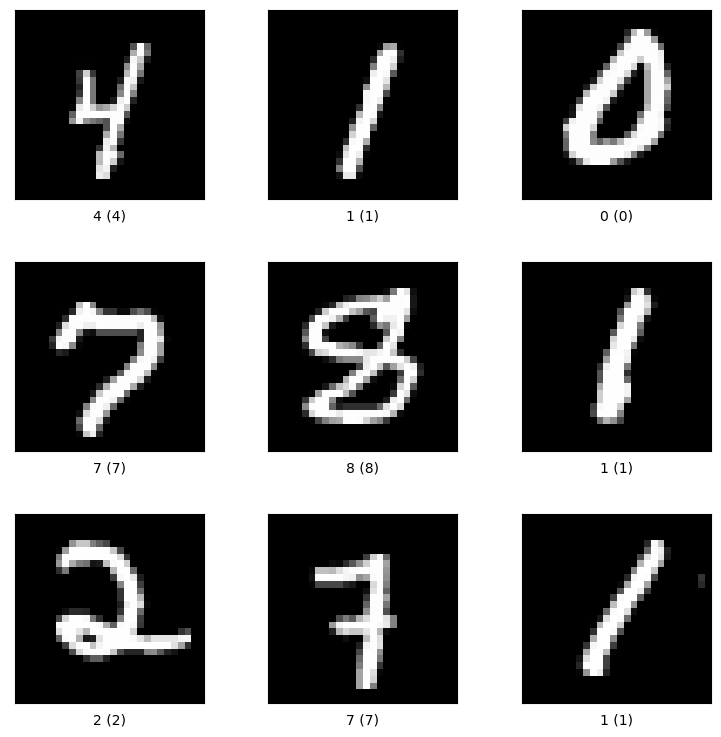

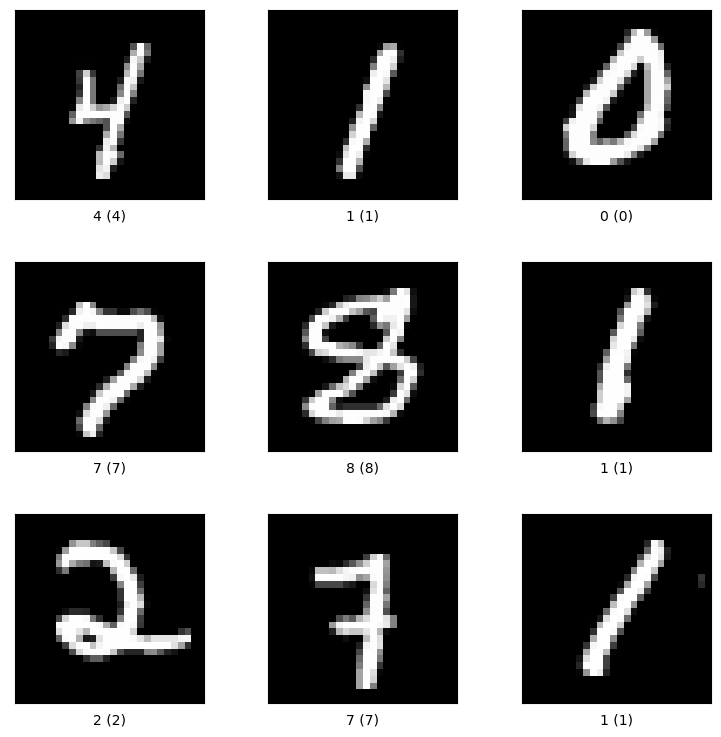

In [3]:
tfds.show_examples (train, info)

In [2]:
def preprocess(data):
    # RESHAPE
    data = data.map(lambda img, target: (tf.reshape(img, (28**2,)), target))
    # DATA TYPE
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # NORMALIZE
    data = data.map(lambda img, target: (img/128. - 1., target))
    # ONE HOT ENCODING
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # DATAFLOW PREP
    data = data.cache()
    data = data.shuffle(1000, seed=42)
    data = data.batch(32)
    data = data.prefetch(20)
    return data

train = train.apply(preprocess)
test  = test.apply(preprocess)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
class Affine(tf.keras.layers.Layer):
    name = 'Affine'
    def __init__(self, n_output, activation, **kwargs):
        super().__init__(**kwargs)
        self.n_output   = n_output
        self.activation = activation if activation is not None else tf.identity
    

    def build(self, n_input):
        self.n_input = n_input[-1]
        limit = math.sqrt(6/(self.n_input + self.n_output))
        self.W = tf.Variable(tf.random.uniform((self.n_input, self.n_output), -limit, limit))
        self.b = tf.Variable(tf.zeros(shape=(1, self.n_output)))
        
    
    @tf.function
    def call(self, x):
        return self.activation(x @ self.W + self.b)

In [4]:
class Vanilla(tf.keras.Model):
    def __init__(self, sizes, activations, **kwargs):
        super().__init__(**kwargs)
        self.layers_list = [Affine(size, activation) for size, activation in zip(sizes, activations)]
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
        self.loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
        
    def __iter__(self):
        return iter(self.layers)

    
    @tf.function
    def call(self, x):
        for layer in self:
            x = layer(x)
        return x
    
    
    @tf.function
    def train_step(self, X, T, l2_reg=1e-2):
        # TRAIN NETWORK
        with tf.GradientTape() as tape:
            Y_logit = self(X)
            L = self.loss(T, Y_logit)
            for layers in self:
                W, b = layers.trainable_weights
                L += l2_reg * (tf.reduce_sum(W**2) + tf.reduce_sum(b**2))
        gradient = tape.gradient(L, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))
        # UPDATE METRICS
        Y = tf.nn.softmax(Y_logit)
        self.loss_metric.update_state(L)
        self.accuracy_metric.update_state(T, Y)
        return {metric.name: float(metric.result()) for metric in self.metrics}
    
    
    @tf.function
    def test_step(self, X, T):
        # COMPUTE METRICS
        Y_logit = self(X)
        Y = tf.nn.softmax(Y_logit)
        L = self.loss(T, Y_logit)
        # UPDATE METRICS
        self.loss_metric.update_state(L)
        self.accuracy_metric.update_state(T, Y)
        return {metric.name: metric.result() for metric in self.metrics}

In [5]:
model = Vanilla([128, 64, 32, 10], [tf.nn.relu, tf.nn.relu, tf.nn.relu, None])
print(model(np.zeros((1, 28**2))).shape)
model.summary()

(1, 10)
Model: "vanilla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Affine (Affine)             multiple                  100480    
                                                                 
 Affine (Affine)             multiple                  8256      
                                                                 
 Affine (Affine)             multiple                  2080      
                                                                 
 Affine (Affine)             multiple                  330       
                                                                 
Total params: 111,150
Trainable params: 111,146
Non-trainable params: 4
_________________________________________________________________


In [6]:
import datetime


# DEFINE PATHS
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/{current_time}/train"
val_log_path = f"logs/{current_time}/val"

# CONSTRUCT WRITERS
writer_train = tf.summary.create_file_writer(train_log_path)
writer_val   = tf.summary.create_file_writer(val_log_path)

In [7]:
from tqdm.notebook import tqdm


def training(epochs, model, train, test):
    with tqdm(range(epochs), leave=True) as out_bar:
        for epoch in out_bar:
            with tqdm(train, leave=False) as in_bar:
                out_bar.set_description('TRAINING')
                for X, T in in_bar:
                    metrics = model.train_step(X, T)
                    with writer_train.as_default():
                        for metric in model.metrics:
                            tf.summary.scalar(metric.name, metric.result(), step=epoch)
                    in_bar.set_postfix({key: value.numpy() for key, value in metrics.items()})
                    model.reset_metrics()
            with tqdm(test, leave=False) as in_bar:
                out_bar.set_description('TESTING')
                for X, T in in_bar:
                    metrics = model.test_step(X, T)
                    with writer_val.as_default():
                        for metric in model.metrics:
                            tf.summary.scalar(metric.name, metric.result(), step=epoch)
                    in_bar.set_postfix({key: value.numpy() for key, value in metrics.items()})
                    model.reset_metrics()

In [8]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [9]:
training(epochs=10, model=model, train=train, test=test)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

2023-02-14 23:22:53.462059: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f46b000ecc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 23:22:53.462078: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2023-02-14 23:22:53.465070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-14 23:22:53.477856: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most a

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_18538/3749115782.py", line 1, in <module>
      training(epochs=10, model=model, train=train, test=test)
    File "/tmp/ipykernel_18538/1435350078.py", line 10, in training
      metrics = model.train_step(X, T)
    File "/tmp/ipykernel_18538/1869805425.py", line 37, in train_step
      self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))
    File "/home/mortimer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/mortimer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/mortimer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/mortimer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/mortimer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_step_1830]

In [78]:
model.save_weights('mnist_vanilla_v1', save_format='tf')

In [77]:
X, T = batch = next(iter(test.batch(200)))
Y_logits = model(X)
Y = tf.nn.softmax(Y_logits)
print(f"{round(np.mean(np.argmax(Y, axis=2) == np.argmax(T, axis=2)) * 100, 1)}%")

92.4%
